In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models

import time

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
def img_resize(x):
    x = T.functional.to_tensor(x)
    x = T.functional.resize(x, [256, 256], antialias=False)
    return x

def img_augment(x, y):
    rand = torch.rand(5)
    angle = rand[0].item() * 20 - 10 # +-10 degrees rotation
    offsetx = rand[1].item() * 100 - 50 # +-50 pixel translation
    offsety = rand[2].item() * 100 - 50 # +-50 pixel translation
    scale = 1.0 # rand[3].item() * 0.5 + 0.75 # +-25% scale
    shear = rand[4].item() * 20 - 10 # +-10 degrees shear

    x = img_resize(x)
    y = img_resize(y)
    x = T.functional.pad(x, 128, padding_mode="reflect")
    y = T.functional.pad(y, 128, padding_mode="reflect")

    x = T.functional.affine(x, angle, [offsetx, offsety], scale, shear)
    y = T.functional.affine(y, angle, [offsetx, offsety], scale, shear)
    
    x = T.functional.center_crop(x, 256)
    y = T.functional.center_crop(y, 256)
        
    return x, y

In [5]:
dataset = torchvision.datasets.VOCSegmentation(".", image_set="trainval", download=True, transform=lambda i: img_resize(i), target_transform=lambda i: img_resize(i))
dataset_aug = torchvision.datasets.VOCSegmentation(".", image_set="trainval", download=True, transforms=lambda x, y: img_augment(x, y))
assert(len(dataset) == len(dataset_aug))

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [6]:
batch_size = 4
train_cutoff = int(len(dataset) * 0.9)
train_data = D.DataLoader(D.Subset(dataset_aug, range(train_cutoff)), batch_size=batch_size, num_workers=4)
val_data = D.DataLoader(D.Subset(dataset, range(train_cutoff, len(dataset))), batch_size=batch_size, num_workers=4)

In [7]:
def train(data, model, optimizer):
    losses = []
    model.train()
    for x, y in data:
        x, y = x.to(device), y.to(device)

        pred = model.forward(x)
        loss = model.loss(pred, y)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return torch.tensor(losses).mean().item()

In [8]:
@torch.no_grad()
def eval(data, model):
    loss = 0
    model.eval()
    for x, y in data:
        x, y = x.to(device), y.to(device)
        pred = model.forward(x)
        loss += model.loss(pred, y).item()
    return loss / len(data)

In [9]:
def trainloop(model, epochs=5, optimizer=torch.optim.AdamW, **optargs):
    optimizer = optimizer(model.parameters(), **optargs)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    start = time.time()
    train_losses, val_losses = [], []
    for e in range(epochs):
        epoch_start = time.time()
        train_loss = train(train_data, model, optimizer)
        val_loss = eval(val_data, model)
        print(f"\rEpoch {e}/{epochs}: {time.time()-epoch_start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}, lr {optimizer.param_groups[0]['lr']}", end="")
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    nparams = sum(p.numel() for p in model.parameters())
    print(f"\rTrain [{nparams/1e6:.3f}M params]: {epochs} epochs took {time.time()-start:.2f} sec, train loss {train_loss:>8f}, val loss {val_loss:>8f}")
    plt.plot(train_losses, label="train")
    plt.plot(val_losses, label="val")
    plt.legend()
    plt.show()

In [10]:
def weight_init(m):
    if isinstance(m, nn.Conv2d):
        I.xavier_normal_(m.weight)
        I.constant_(m.bias, 0)

In [11]:
class SegBlock(nn.Module):
    def __init__(self, inc, midc, outc):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(inc, midc, kernel_size=3, padding=1),
            nn.BatchNorm2d(midc),
            nn.ReLU(),
            nn.Conv2d(midc, outc, kernel_size=3, padding=1),
            nn.BatchNorm2d(outc),
            nn.ReLU())
        
    def forward(self, x):
        return self.layers(x)
        
class SegNet(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth

        self.encoder = []
        for i in range(depth):
            self.encoder.append(SegBlock(3 if i == 0 else channels << (i-1), channels << i, channels << i))
            self.encoder.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encoder = nn.ModuleList(self.encoder)

        self.transform = SegBlock(channels << (depth - 1), channels << depth, channels << depth)

        self.decoder = []
        for i in range(depth, 0, -1):
            self.decoder.append(nn.ConvTranspose2d(channels << i, channels << i, kernel_size=2, stride=2))
            # note: between these layers we'll have concat which will double channel count
            self.decoder.append(SegBlock((channels << i) + (channels << (i-1)), channels << (i-1), channels << (i-1)))
        self.decoder = nn.ModuleList(self.decoder)
            
        self.predict = nn.Sequential(
            SegBlock(channels, channels, channels),
            nn.Conv2d(channels, 1, kernel_size=1))

        self.apply(weight_init)
        
    # image => image
    def forward(self, x):
        copies = []
        for i in range(self.depth):
            conv, pool = self.encoder[i*2], self.encoder[i*2+1]
            x = conv(x)
            copies.append(x)
            x = pool(x)
            
        x = self.transform(x)
        
        for i in range(self.depth):
            up, conv = self.decoder[i*2], self.decoder[i*2+1]
            x = up(x)
            x = torch.cat((x, copies[-(i+1)]), dim=1)
            x = conv(x)
        
        y = self.predict(x)
        y = F.sigmoid(y)
        return y
    
    # prediction, gt => loss scalar
    def loss(self, p, y):
        bce = F.binary_cross_entropy(p, y)
        dice = 2 * (p * y).sum() / (p.sum() + y.sum())
        return bce - torch.log(dice)

Train [9.271M params]: 30 epochs took 536.57 sec, train loss 1.304305, val loss 1.437601


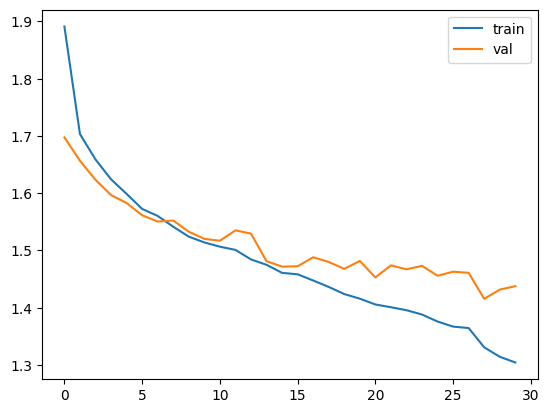

In [12]:
# UNet that loosely follows the architecture from the UNet paper but has slightly different setup; this cell has a scaled down version so that it trains faster
torch.manual_seed(42)
net = SegNet(depth=5, channels=16).to(device)
trainloop(net, epochs=30, weight_decay=0.01)

In [13]:
class SegNetVGG(nn.Module):
    def __init__(self, vgg):
        super().__init__()
        
        self.relu = nn.ReLU(inplace=True)

        # we will use VGG feature subnet as encoder; freeze the weights
        self.encoder = vgg.features
        for p in self.encoder.parameters():
            p.requires_grad = False
            
        # instead of spending time figuring out a generic reconstruction, let's hardcode the decoder structure for now
        # VGG11 has 5 downsampling steps; it starts from 64 channels and ends with 512 channels in the final feature map
        self.transform = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        
        # as an experiment, we'll use single-conv upsampling blocks instead of a slightly more complex setup that UNet uses
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.Conv2d(512 + 256, 512, kernel_size=3, padding=1),
            
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.Conv2d(512 + 256, 512, kernel_size=3, padding=1),

            nn.ConvTranspose2d(512, 128, kernel_size=2, stride=2),
            nn.Conv2d(256 + 128, 256, kernel_size=3, padding=1),

            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.Conv2d(128 + 64, 128, kernel_size=3, padding=1),

            nn.ConvTranspose2d(128, 32, kernel_size=2, stride=2),
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
        )

        self.predict = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid())

    # image => image
    def forward(self, x):
        cdim = x.dim() - 3 # pick C from B?, C, H, W
        
        # renormalize image using VGG11 coeffs
        x = (x - 0.456) / 0.224

        # encoder
        x = self.relu(self.encoder[0](x)) # conv 3->64
        e0 = x # 64
        x = self.encoder[2](x) # maxpool
        x = self.relu(self.encoder[3](x)) # conv 64->128
        e1 = x # 128
        x = self.encoder[5](x) # maxpool
        x = self.relu(self.encoder[6](x)) # conv 128->256
        x = self.relu(self.encoder[8](x)) # conv 256->256
        e2 = x # 256
        x = self.encoder[10](x) # maxpool
        x = self.relu(self.encoder[11](x)) # conv 256->512
        x = self.relu(self.encoder[13](x)) # conv 512->512
        e3 = x # 512
        x = self.encoder[15](x) # maxpool
        x = self.relu(self.encoder[16](x)) # conv 512->512
        x = self.relu(self.encoder[18](x)) # conv 512->512
        e4 = x # 512
        x = self.encoder[20](x) # maxpool
        
        # bottleneck
        x = self.relu(self.transform(x))
        
        # decoder
        x = self.relu(self.decoder[0](x)) # upconv 512->256
        x = torch.cat((e4, x), dim=cdim)
        x = self.relu(self.decoder[1](x)) # conv 512+256->512

        x = self.relu(self.decoder[2](x)) # upconv 512->256
        x = torch.cat((e3, x), dim=cdim)
        x = self.relu(self.decoder[3](x)) # conv 512+256->512

        x = self.relu(self.decoder[4](x)) # upconv 512->128
        x = torch.cat((e2, x), dim=cdim)
        x = self.relu(self.decoder[5](x)) # conv 256+128->256

        x = self.relu(self.decoder[6](x)) # upconv 256->64
        x = torch.cat((e1, x), dim=cdim)
        x = self.relu(self.decoder[7](x)) # conv 128+64->128

        x = self.relu(self.decoder[8](x)) # upconv 128->32
        x = torch.cat((e0, x), dim=cdim)
        x = self.relu(self.decoder[9](x)) # conv 64+32->32

        return self.predict(x)

    # prediction, gt => loss scalar
    def loss(self, p, y):
        bce = F.binary_cross_entropy(p, y)
        dice = 2 * (p * y).sum() / (p.sum() + y.sum())
        return bce - torch.log(dice)

Train [21.187M params]: 30 epochs took 1011.07 sec, train loss 0.726728, val loss 1.319711


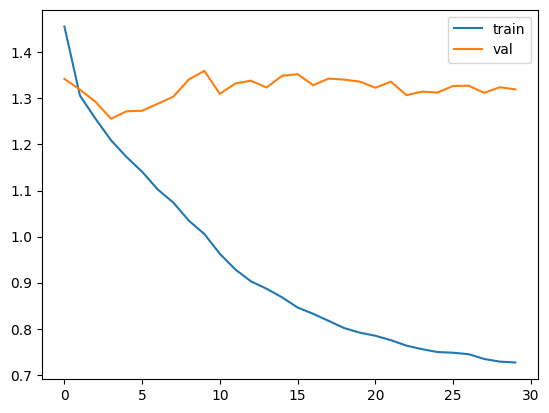

In [14]:
torch.manual_seed(42)
netvgg = SegNetVGG(torchvision.models.vgg11(weights="DEFAULT")).to(device)
trainloop(netvgg, epochs=30, weight_decay=0.01)

In [16]:
# ^ is obviously overfitted but I don't care about this right now :)

In [90]:
# run visualize() to show a few examples of both models
def visualize(num=5):
    idx = torch.randint(len(dataset), (num,))
    bx = torch.stack([dataset[i][0] for i in idx])
    by = torch.stack([dataset[i][1] for i in idx])
    bps = net(bx.to(device)).cpu().detach()
    bpv = netvgg(bx.to(device)).cpu().detach()

    f, axarr = plt.subplots(idx.shape[0], 4, figsize=(24,24), squeeze=False)
    for i in range(idx.shape[0]):
        ix = idx[i].item()
        axarr[i][0].imshow(dataset[ix][0].permute(1, 2, 0))
        axarr[i][1].imshow(dataset[ix][1].permute(1, 2, 0))
        axarr[i][2].imshow(bps[i].permute(1, 2, 0) > 0.3)
        axarr[i][3].imshow(bpv[i].permute(1, 2, 0) > 0.3)
        for j in range(4):
            axarr[i][j].axis('off')
    plt.tight_layout()